In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv', encoding = "ISO-8859-1")

#convert day to datetime type
df.start = pd.to_datetime(df.start)
df.end = pd.to_datetime(df.end)
df.dob = pd.to_datetime(df.dob)
df.dtypes

#elo gain from each tournament
df['delo'] = df.endelo64 - df.startelo64

#cumulative sum of delo
cumsums = df[['player', 'start', 'delo']].groupby(['player', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['player', 'start'])
df['rating'] = cumsums
df = df.reset_index()

#calculate age in year
df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)

#experience
for player in df.player.unique():
    try:
        dfid = pd.DataFrame(df[df['player'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['player'] = player
        dfid2 = pd.concat([dfid2, dfid])
    except NameError:
        dfid2 = dfid
        continue

df = pd.merge(df, dfid2, how='left', on=['player', 'tour'])

#init is rating + initial mmr (assume first team = player's calibration)
init = df[df['startelo64'].notnull()].sort_values('start')[['startelo64', 'player']].groupby('player').first().reset_index().rename(columns={'startelo64': 'init'})
df = pd.merge(df, init, how='left', on='player')
df.init = df.rating + df.init

In [23]:
df.sample(5)

,player,start,country,team,position,dob,tour,end,place,prize,...,endelo64,delo,rating,age,exp,init,zone,expc,agec,pos
4959,fng,2016-05-09,Belarus,Virtus.pro,3,1995-09-24,EPICENTER 2016,2016-05-15,7,10000.0,...,1077.437934,-30.353753,-274.631386,20.624230,34.0,713.304697,Cis,"(30.0, 85.0]","(15.246, 21.528]",core
2308,iceiceice,2014-09-12,Singapore,Vici Gaming,3,1990-06-17,ECL 2014 Autumn,2014-12-30,3,1610.0,...,1186.225454,-33.973973,446.480626,24.238193,24.0,1508.766563,Sea,"(17.0, 30.0]","(23.944, 32.233]",core
4247,kuku,2017-04-24,Philippines,TNC Pro Team,2,1996-09-21,The Kiev Major 2017,2017-04-30,9,62500.0,...,1099.218497,-74.258421,-54.829147,20.588638,4.0,1036.053840,Sea,"(-0.001, 8.0]","(15.246, 21.528]",core
7241,puppey,2013-09-02,Estonia,Natus Vincere,5,1990-03-06,RaidCall EMS One Fall Season,2013-12-08,3,4000.0,...,1320.234333,-47.197233,400.539098,23.493498,25.0,1573.836491,Eu,"(17.0, 30.0]","(21.528, 23.944]",support
4133,fy,2017-05-18,China,Team VGJ,4,1995-02-12,StarLadder i-League Invitational #2,2017-05-21,7,2500.0,...,1079.490853,-1.657926,-672.932250,22.261465,54.0,340.652577,China,"(30.0, 85.0]","(21.528, 23.944]",support


In [4]:
df = df.dropna()

In [5]:
Region = {'SEA' : ['Malaysia', 'Singapore', 'Thailand', 'Australia', 'South Korea', 'Philippines', 'Vietnam', 'Indonesia'], 
          'EU': ['France', 'Germany', 'Finland', 'Israel', 'Denmark', 'Romania', 'Jordan', 'Sweden', 'Estonia', 'Macedonia', 'Poland', 'Croatia', 'Greece', 'Lebanon', 'Albenia', 'Bosnia and Herzegovina', 'Netherlands', 'Serbia', 'Bulgaria', 'United Kingdom', 'Turkey', 'Slovakia', 'Czech Republic'],
          'CIS': ['Ukraine', 'Russia', 'Belarus', 'Kazakhstan', 'Kyrgyzstan'],
          'CN': ['China', 'Macau'],
          'NA': ['United State', 'Canada', 'Pakistan', 'Mexico'],
          'SA': ['Peru', 'Argentina', 'Brazil', 'Venezuela']}

In [6]:
#divide country into 6 group by region
#0 = Others
df['zone'] = 'America'
df.loc[df.country.isin(Region['SEA']), 'zone'] = 'Sea'
df.loc[df.country.isin(Region['EU']), 'zone'] = 'Eu'
df.loc[df.country.isin(Region['CIS']), 'zone'] = 'Cis'
df.loc[df.country.isin(Region['CN']), 'zone'] = 'China'

In [7]:
df.groupby('zone').size()

zone
America     614
China      1330
Cis         998
Eu         1187
Sea         538
dtype: int64

In [8]:
df['expc'] = pd.qcut(df.exp, 4)
df['agec'] = pd.qcut(df.age, 3)

In [9]:
#average rating of player given position and experience
df[['expc', 'init', 'age']].groupby(['expc']).mean()

,init,age
expc,,
"(-0.001, 8.0]",1147.357375,21.244715
"(8.0, 17.0]",1220.272627,22.151826
"(17.0, 30.0]",1289.834800,23.000618
"(30.0, 85.0]",1227.347156,24.604111


In [10]:
#pos 1 = core, pos 2 = support
df['pos'] = 'core'
df.loc[df['position'] > 3, 'pos'] = 'support'

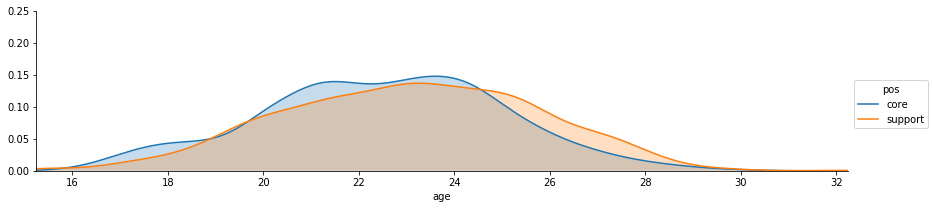

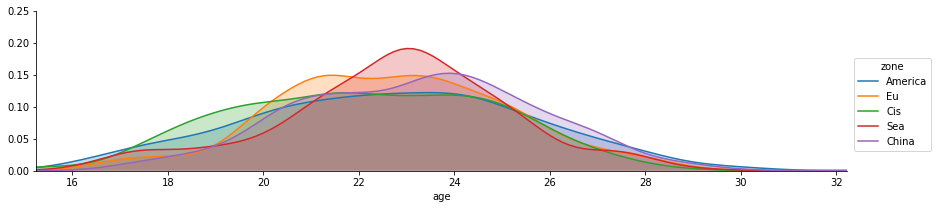

In [11]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'age', shade= True )
grid1.set(xlim=(df['age'].min() , df['age'].max()))
grid1.set(ylim=(0, 0.25))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'zone', aspect=4 )
grid2.map(sns.kdeplot, 'age', shade= True )
grid2.set(xlim=(df['age'].min() , df['age'].max()))
grid2.set(ylim=(0, 0.25))
grid2.add_legend()

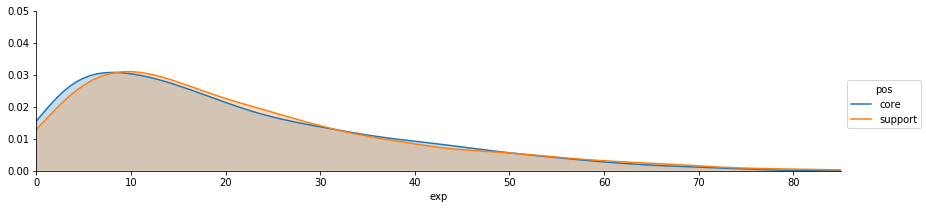

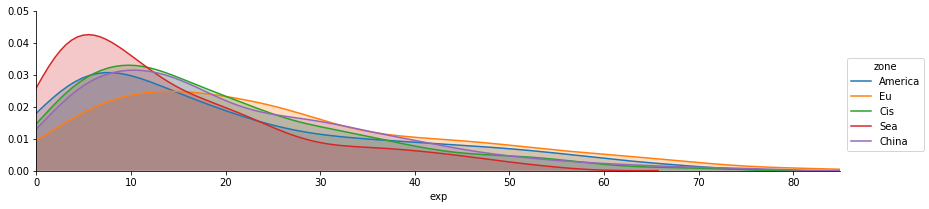

In [12]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'exp', shade= True )
grid1.set(xlim=(df['exp'].min() , df['exp'].max()))
grid1.set(ylim=(0, 0.05))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'zone', aspect=4 )
grid2.map(sns.kdeplot, 'exp', shade= True )
grid2.set(xlim=(df['exp'].min() , df['exp'].max()))
grid2.set(ylim=(0, 0.05))
grid2.add_legend()

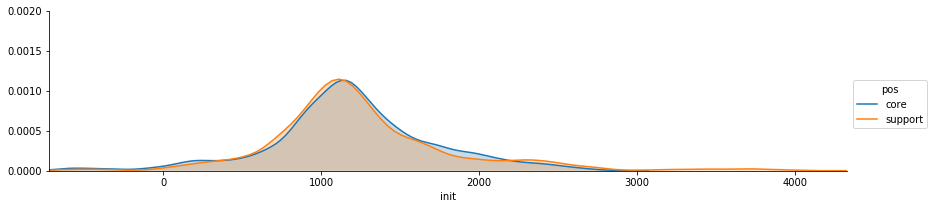

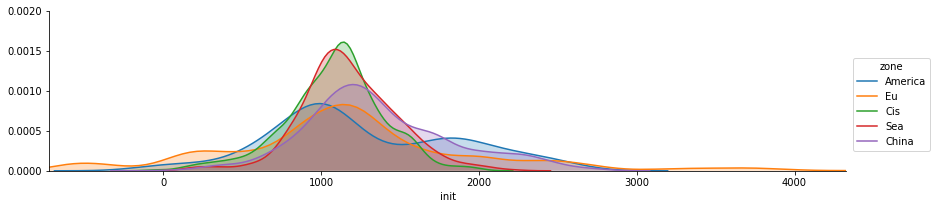

In [13]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'init', shade= True )
grid1.set(xlim=(df['init'].min() , df['init'].max()))
grid1.set(ylim=(0, 0.002))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'zone', aspect=4 )
grid2.map(sns.kdeplot, 'init', shade= True )
grid2.set(xlim=(df['init'].min() , df['init'].max()))
grid2.set(ylim=(0, 0.002))
grid2.add_legend()

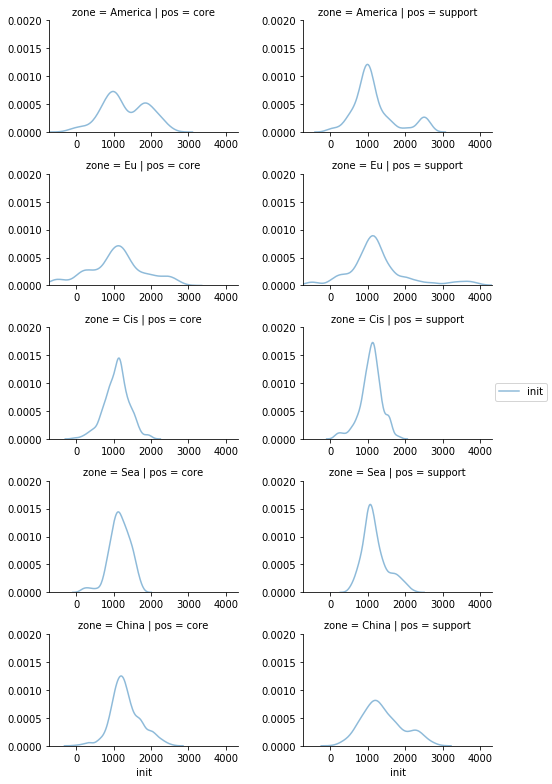

In [14]:
grid = sns.FacetGrid(df, col='pos', row='zone', size=2.2, aspect=1.6)
grid.map(sns.kdeplot, 'init', alpha=.5)
grid.set(xlim=(df['init'].min() , df['init'].max()))
grid.set(ylim=(0, 0.002))
grid.add_legend();

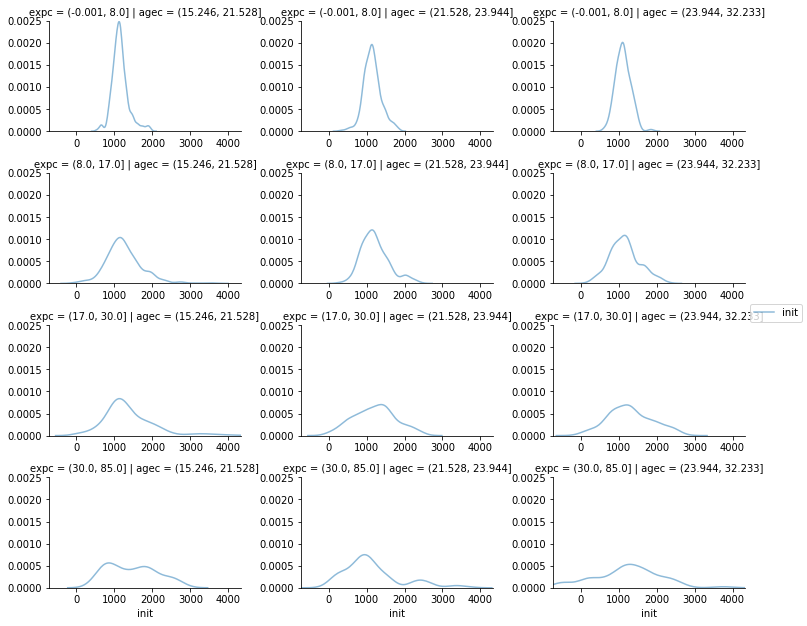

In [15]:
grid = sns.FacetGrid(df, col='agec', row='expc', size=2.2, aspect=1.6)
grid.map(sns.kdeplot, 'init', alpha=.5)
grid.set(xlim=(df['init'].min() , df['init'].max()))
grid.set(ylim=(0, 0.0025))
grid.add_legend();

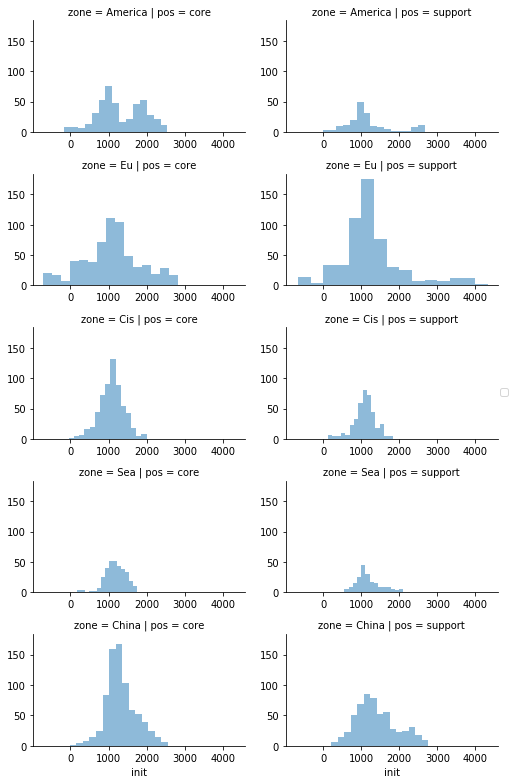

In [16]:
grid = sns.FacetGrid(df, col='pos', row='zone', size=2.2, aspect=1.6)
grid.map(plt.hist, 'init', alpha=.5, bins=15)
grid.add_legend();

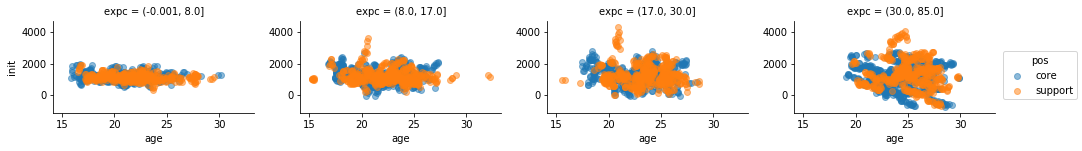

In [17]:
grid = sns.FacetGrid(df, col='expc', hue='pos', size=2.2, aspect=1.6)
grid.map(plt.scatter,'age', 'init', alpha=.5)
grid.add_legend();

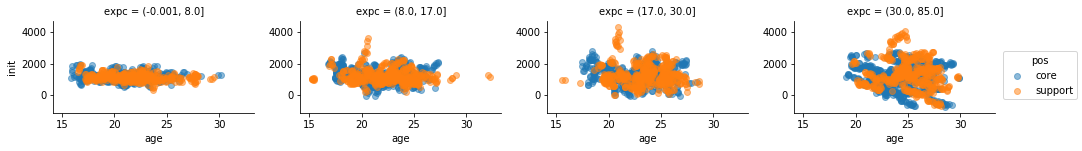

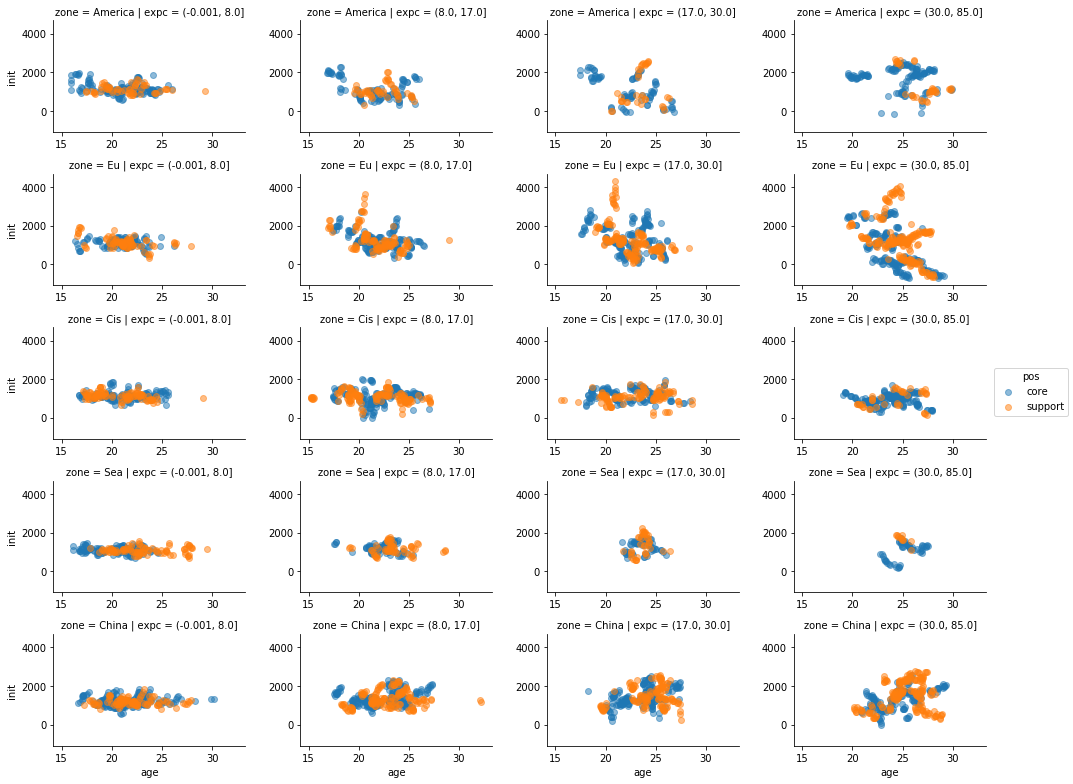

In [18]:
grid1 = sns.FacetGrid(df, col='expc', hue='pos', size=2.2, aspect=1.6)
grid1.map(plt.scatter,'age', 'init', alpha=.5)
grid1.add_legend();

grid2 = sns.FacetGrid(df, col='expc', row='zone', hue='pos', size=2.2, aspect=1.6)
grid2.map(plt.scatter,'age', 'init', alpha=.5)
grid2.add_legend();

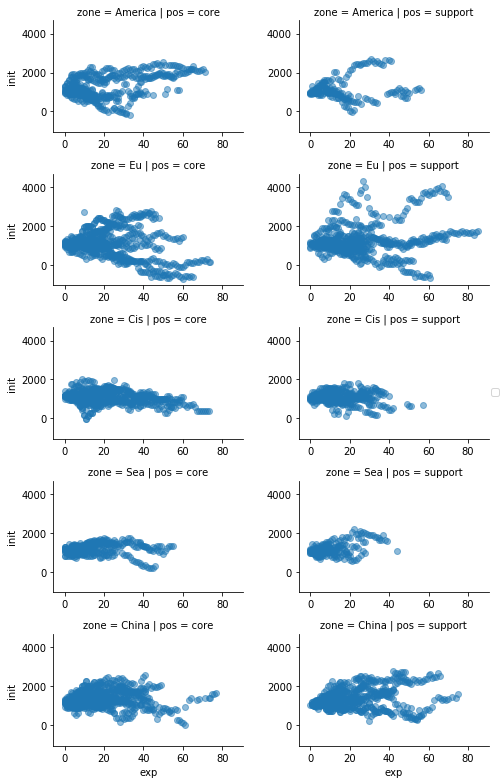

In [19]:
grid = sns.FacetGrid(df, col='pos', row='zone', size=2.2, aspect=1.6)
grid.map(plt.scatter,'exp', 'init', alpha=.5)
grid.add_legend();